In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_datareader.data as reader
import datetime as dt
from typing import Iterable, Union
from sklearn.metrics import confusion_matrix

In [2]:
start = dt.datetime(2021,11,10)   # Rivian's IPO date
end = dt.datetime.today().date()

In [3]:
sp500_ticker = ('^GSPC')
rivian_ticker = ('RIVN')
tesla_ticker = ('TSLA')
mullen_ticker = ('MULN')
lucid_ticker = ('LCID')

In [4]:
# Loading the datasets for each asset
sp500_df = reader.get_data_yahoo(sp500_ticker, start, end)
rivn_df = reader.get_data_yahoo(rivian_ticker, start, end)
tsla_df = reader.get_data_yahoo(tesla_ticker, start, end)
muln_df = reader.get_data_yahoo(mullen_ticker, start, end)
lcid_df = reader.get_data_yahoo(lucid_ticker, start, end)

In [5]:
rivn_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-10,119.459999,95.199997,106.750000,100.730003,103679500,100.730003
2021-11-11,125.000000,108.010002,114.625000,122.989998,83668200,122.989998
2021-11-12,135.199997,125.250000,128.645004,129.949997,50437500,129.949997
2021-11-15,152.529999,127.510002,130.800003,149.360001,64982300,149.360001
2021-11-16,179.470001,153.779999,163.800003,172.009995,94036600,172.009995


In [6]:
def preprocess_dfs(list_of_dfs: Iterable) -> Iterable:
    processed_dfs = []
    for df in list_of_dfs:
        df = df.rename(columns={"Adj Close": "closing_price"})
        processed_dfs += [df.reset_index()]
    
    return processed_dfs

In [7]:
def calculate_daily_returns(list_of_dfs: Iterable) -> Iterable:
    enriched_dfs = []
    
    for df in list_of_dfs:
        df["daily_return"] = np.log(df["closing_price"]/df["closing_price"].shift())
        df = df.dropna()
        enriched_dfs += [df]
    
    return enriched_dfs

In [8]:
processed_dfs = preprocess_dfs([sp500_df, rivn_df, tsla_df, muln_df, lcid_df])

In [9]:
processed_dfs = calculate_daily_returns(processed_dfs)

In [10]:
sp500_df, rivn_df, tsla_df, muln_df, lcid_df = processed_dfs

In [11]:
ticker_list = [rivian_ticker, mullen_ticker, tesla_ticker, lucid_ticker]
ticker_to_df = {rivian_ticker: rivn_df, mullen_ticker: muln_df, tesla_ticker: tsla_df, lucid_ticker: lcid_df}

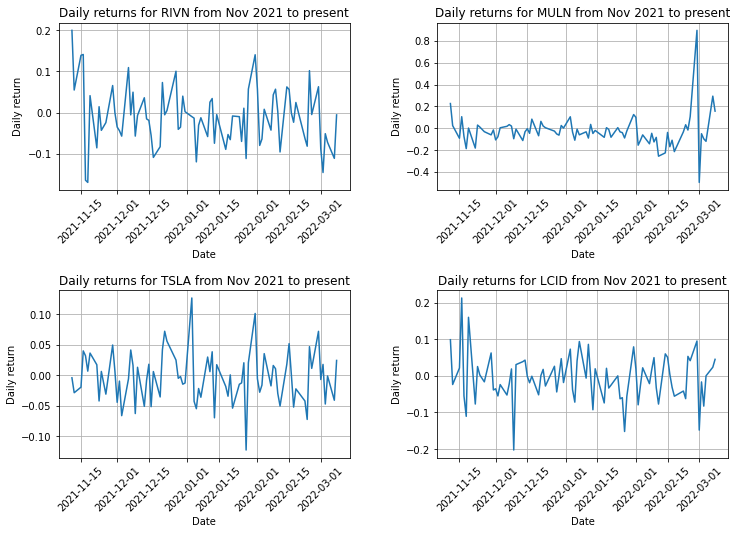

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(12, 8))

grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.6)

for i in range(0, 2):
    for j in range(0, 2):
        index = i*2+j
        target_ticker = ticker_list[index]
        df = ticker_to_df[target_ticker]
        ax = plt.subplot(grid[i, j])
        plt.plot(df["Date"], df["daily_return"])
        plt.xticks(rotation=45)
        plt.grid()
        plt.title(f"Daily returns for {target_ticker} from Nov 2021 to present")
        plt.xlabel("Date")
        plt.ylabel("Daily return")

plt.show()

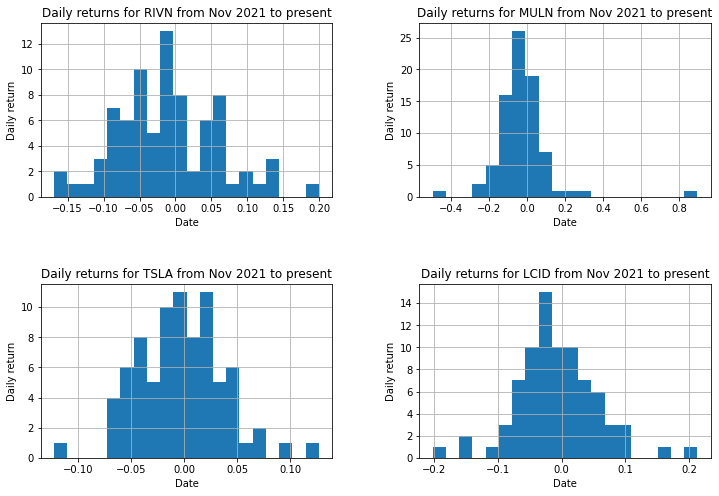

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(12, 8))

grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.5)

for i in range(0, 2):
    for j in range(0, 2):
        index = i*2+j
        target_ticker = ticker_list[index]
        df = ticker_to_df[target_ticker]
        ax = plt.subplot(grid[i, j])
        plt.hist(df["daily_return"], bins=20)
        plt.grid()
        plt.title(f"Daily returns for {target_ticker} from Nov 2021 to present")
        plt.xlabel("Date")
        plt.ylabel("Daily return")

plt.show()

In [14]:
daily_returns_df = pd.DataFrame()
for ticker in ticker_list:
    df = ticker_to_df[ticker]
    col_name = ticker+"_daily_return"
    daily_returns_df[col_name] = df["daily_return"]

daily_returns_df["SP500_daily_return"] = sp500_df["daily_return"]

[Text(0.5, 1.0, 'Is pairs-trading possible with EV stocks?')]

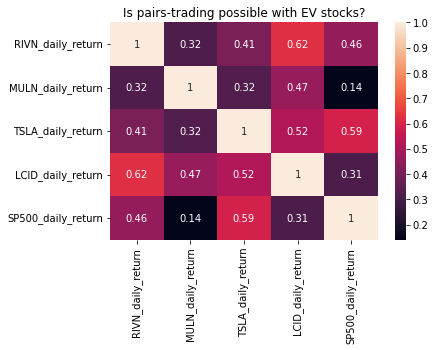

In [26]:
sns.heatmap(daily_returns_df.corr(), annot=True).set(title="Is pairs-trading possible with EV stocks?")

In [77]:
returns_wrt_index_df

,RIVN_daily_return,MULN_daily_return,TSLA_daily_return,LCID_daily_return
1,0.199109,0.225762,-0.004717,0.098211
2,0.047850,0.017033,-0.035898,-0.030817
3,0.139221,-0.091292,-0.019562,0.021406
4,0.137335,0.102010,0.036126,0.208893
5,-0.160862,-0.072440,0.034589,-0.052373
...,...,...,...,...
76,-0.163350,-0.068233,-0.000675,-0.035014
77,-0.045475,-0.091063,-0.041972,-0.077388
78,-0.063682,-0.111223,0.006773,0.007966
79,-0.080593,0.323954,-0.011081,0.053545


In [75]:
returns_wrt_index_df = daily_returns_df.drop("SP500_daily_return", axis=1)

for col in returns_wrt_index_df.columns:
    returns_wrt_index_df[col] = returns_wrt_index_df[col] - sp500_df["daily_return"]

[Text(0.5, 1.0, 'Do EV stocks perform equally with respect to market?')]

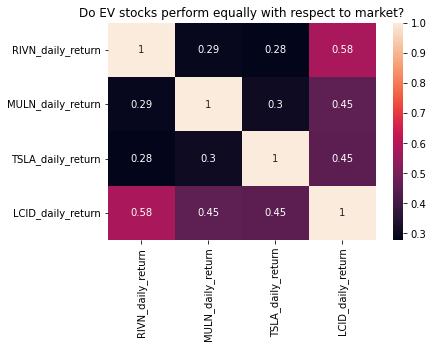

In [33]:
sns.heatmap(returns_wrt_index_df.corr(), annot=True).set(title="Do EV stocks perform equally with respect to market?")

In [69]:
returns_binary_df = daily_returns_df.drop("SP500_daily_return", axis=1)
returns_binary_df = (returns_binary_df[col] >= 0)
returns_binary_df = returns_binary_df.replace({True: "Up", False: "Down"})

In [79]:
returns_binary_wrt_index_df = (returns_wrt_index_df >= 0)
returns_binary_wrt_index_df = returns_binary_wrt_index_df.replace({True: "Up", False: "Down"})

In [84]:
def generate_comparison_cf_matrix(df, ticker1: str, ticker2: str, wrt_market: bool = False) -> None:
    col1 = ticker1 + "_daily_return"
    col2 = ticker2 + "_daily_return"
    
    cf_matrix = confusion_matrix(df[col1], df[col2], normalize="all")

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    if wrt_market:
        ax.set_title(f'How often do {ticker1} and {ticker2} beat the market together (or vice versa)? \n')
        ax.set_xlabel(f'\n {ticker2} daily return - SP500 daily return')
        ax.set_ylabel(f'{ticker1} daily return - SP500 daily return')
        ax.xaxis.set_ticklabels(['Lower than market','Better than market'])
        ax.yaxis.set_ticklabels(['Lower than market','Better than market'])
    else:
        ax.set_title(f'How often do {ticker1} and {ticker2} move in the same direction? \n')
        ax.set_xlabel(f'\n {ticker2} daily return')
        ax.set_ylabel(f'{ticker1} daily return');
        ax.xaxis.set_ticklabels(['Down','Up'])
        ax.yaxis.set_ticklabels(['Down','Up'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

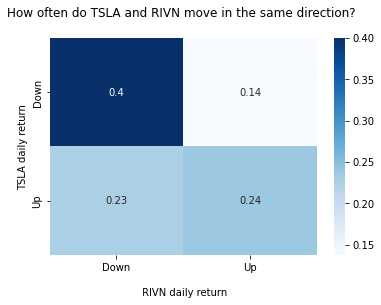

In [85]:
generate_comparison_cf_matrix(returns_binary_df, "TSLA", "RIVN")

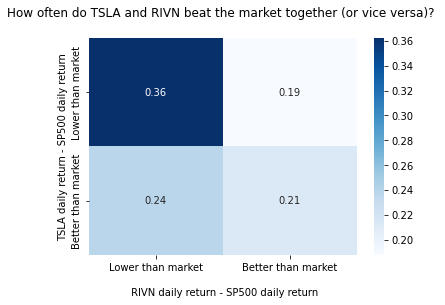

In [86]:
generate_comparison_cf_matrix(returns_binary_wrt_index_df, "TSLA", "RIVN", wrt_market=True)